In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import CIFAR10_utils as utils

# Tune hyperparameters

In [3]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
count = -1
for lr_0, n, random_state, weight_decay in itertools.product(lr_0s, ns, random_states, weight_decays):
    count += 1
    model_name = 'nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}'\
    .format(lr_0, n, random_state, weight_decay)
    print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --random_state={} --tune --wandb --weight_decay={}"'\
          .format(dataset_path, experiments_path, lr_0, model_name, n, prior_path, random_state, weight_decay))
print(count)

    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10' --lr_0=0.1 --model_name='nonlearned_lr_0=0.1_n=10_random_state=1001_weight_decay=0.01' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --random_state=1001 --tune --wandb --weight_decay=0.01"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10' --lr_0=0.1 --model_name='nonlearned_lr_0=0.1_n=10_random_state=1001_weight_decay=0.001' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --random_state=1001 --tune --wandb --weight_decay=0.001"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-le

In [23]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [50000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
prior_scales = np.logspace(0, 9, num=10)
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
count = -1
for lr_0, n, prior_scale, random_state, weight_decay in itertools.product(lr_0s, ns, prior_scales, random_states, weight_decays):
    count += 1
    model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
    .format(lr_0, n, prior_scale, random_state, weight_decay)
    print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --learned_prior --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --random_state={} --tune --wandb --weight_decay={}"'\
          .format(dataset_path, experiments_path, lr_0, model_name, n, prior_path, prior_scale, random_state, weight_decay))
print(count)

    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10' --learned_prior --lr_0=0.1 --model_name='learned_lr_0=0.1_n=50000_prior_scale=1.0_random_state=1001_weight_decay=0.01' --n=50000 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --prior_scale=1.0 --random_state=1001 --tune --wandb --weight_decay=0.01"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10' --learned_prior --lr_0=0.1 --model_name='learned_lr_0=0.1_n=50000_prior_scale=1.0_random_state=1001_weight_decay=0.001' --n=50000 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --prior_scale=1.0 --random_state=1001 --tune --wandb --weight_decay=0.001"
    "python ../src/CIFAR10_main.py --dataset_path='/cluste

# Retrain with selected parameters

In [16]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_val_nll(df):
    return df.val_or_test_nll.values[-1]

def get_val_acc(df):
    return df.val_or_test_acc.values[-1]

def get_last_epoch(df):
    return df.iloc[-1]

def get_best_hyperparameters(experiments_path, lr_0s, ns, random_states, weight_decays, prior_scales=None):
    if prior_scales is None:
        columns = ['lr_0', 'n', 'random_state', 'val_acc', 'weight_decay']
        df = pd.DataFrame(columns=columns)
        for n, random_state in itertools.product(ns, random_states):
            best_val_nll = np.inf
            best_hyperparameters = None
            for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
                model_name = 'nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}'\
                .format(lr_0, n, random_state, weight_decay)
                path =  '{}/{}.csv'.format(experiments_path, model_name)
                val_nll = get_val_nll(get_df(path))
                val_acc = get_val_acc(get_df(path))
                if val_nll < best_val_nll: best_val_nll = val_nll; best_hyperparameters = [lr_0, n, random_state, val_acc, weight_decay]
            df.loc[df.shape[0]] = best_hyperparameters
    else:
        columns = ['lr_0', 'n', 'prior_scale', 'random_state', 'val_acc', 'weight_decay']
        df = pd.DataFrame(columns=columns)
        for n, prior_scale, random_state in itertools.product(ns, prior_scales, random_states):
            best_val_nll = np.inf
            best_hyperparameters = None
            for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
                model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
                .format(lr_0, n, prior_scale, random_state, weight_decay)
                path =  '{}/{}.csv'.format(experiments_path, model_name)
                val_nll = get_val_nll(get_df(path))
                val_acc = get_val_acc(get_df(path))
                if val_nll < best_val_nll: best_val_nll = val_nll; best_hyperparameters = [lr_0, n, prior_scale, random_state, val_acc, weight_decay]
            df.loc[df.shape[0]] = best_hyperparameters
    return df

In [17]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
df = get_best_hyperparameters(experiments_path, lr_0s, ns, random_states, weight_decays)
df

,lr_0,n,random_state,val_acc,weight_decay
0,0.0001,10.0,1001.0,0.000000,0.00010
1,0.0100,10.0,2001.0,0.000000,0.00100
2,0.0010,10.0,3001.0,0.000000,0.01000
3,0.0001,100.0,1001.0,0.425000,0.00001
4,0.0001,100.0,2001.0,0.266667,0.00010
5,0.0001,100.0,3001.0,0.441667,0.00100
6,0.0100,1000.0,1001.0,0.863891,0.00100
7,0.0100,1000.0,2001.0,0.845090,0.00100
8,0.0100,1000.0,3001.0,0.845111,0.00001
9,0.0100,10000.0,1001.0,0.935793,0.00100


In [18]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
count = -1
for row_index, row in df.iterrows():
    count += 1
    model_name = 'nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}'\
    .format(row.lr_0, int(row.n), int(row.random_state), row.weight_decay)
    print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --random_state={} --wandb --weight_decay={}"'\
          .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, int(row.random_state), row.weight_decay))
print(count)

    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10' --lr_0=0.0001 --model_name='nonlearned_lr_0=0.0001_n=10_random_state=1001_weight_decay=0.0001' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --random_state=1001 --wandb --weight_decay=0.0001"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10' --lr_0=0.01 --model_name='nonlearned_lr_0=0.01_n=10_random_state=2001_weight_decay=0.001' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --random_state=2001 --wandb --weight_decay=0.001"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-trans

In [19]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [1000]
prior_scales = np.logspace(0, 9, num=10)
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
weight_decays = [0.0]
df = get_best_hyperparameters(experiments_path, lr_0s, ns, random_states, weight_decays, prior_scales=prior_scales)
df

,lr_0,n,prior_scale,random_state,val_acc,weight_decay
0,0.0100,1000.0,1.000000e+00,1001.0,0.833864,0.0
1,0.1000,1000.0,1.000000e+00,2001.0,0.817475,0.0
2,0.0001,1000.0,1.000000e+00,3001.0,0.780810,0.0
3,0.0100,1000.0,1.000000e+01,1001.0,0.804856,0.0
4,0.1000,1000.0,1.000000e+01,2001.0,0.837519,0.0
5,0.0100,1000.0,1.000000e+01,3001.0,0.807003,0.0
6,0.0100,1000.0,1.000000e+02,1001.0,0.816796,0.0
7,0.0100,1000.0,1.000000e+02,2001.0,0.802877,0.0
8,0.0100,1000.0,1.000000e+02,3001.0,0.799410,0.0
9,0.0100,1000.0,1.000000e+03,1001.0,0.812056,0.0


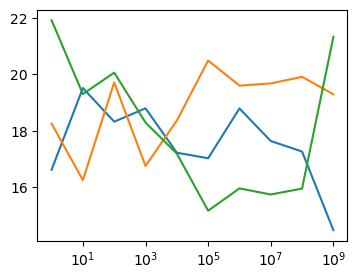

In [20]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=100)
for random_state in random_states:
    ax.plot(df[df.random_state == random_state].prior_scale, 
            100*(1-df[df.random_state == random_state].val_acc))
ax.set_xscale('log')

In [21]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
count = -1
for row_index, row in df.iterrows():
    count += 1
    model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
    .format(row.lr_0, int(row.n), row.prior_scale, int(row.random_state), row.weight_decay)
    print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --learned_prior --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --random_state={} --wandb --weight_decay={}"'\
          .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_scale, int(row.random_state), row.weight_decay))
print(count)

    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10' --learned_prior --lr_0=0.01 --model_name='learned_lr_0=0.01_n=1000_prior_scale=1.0_random_state=1001_weight_decay=0.0' --n=1000 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --prior_scale=1.0 --random_state=1001 --wandb --weight_decay=0.0"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10' --learned_prior --lr_0=0.1 --model_name='learned_lr_0=0.1_n=1000_prior_scale=1.0_random_state=2001_weight_decay=0.0' --n=1000 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --prior_scale=1.0 --random_state=2001 --wandb --weight_decay=0.0"
    "python ../src/CIFAR10_main.py --dataset_path='/cluster/tufts/hughes